# Medtronic Boston Pair
### Entry Threshold:	2.00 | Exit Threshold:	0.50 | Max Duration:	10	
### MA Period:	60 | MA Type:	SMA	StdDev | Period:	60 | Total ROI:	58.06 % | CAGR:	36.11 %	 | Max. DD:	20.43 %
### Sharpe Ratio:	1.147

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import statsmodels
from pandas_datareader import data
import datetime
import quandl

In [2]:
start= datetime.datetime(2018, 1, 1)  # The start of the year for example
end= datetime.datetime(2020, 9, 30)

In [3]:
ticker_1 = "MDT"
ticker_2 = "BSX"

In [4]:
df_tickr1 = data.DataReader(name= ticker_1, data_source= "yahoo", start= start, end= end)
df_tickr2 = data.DataReader(name= ticker_2, data_source= "yahoo", start= start, end= end)

In [5]:
df_tickr1.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-26,112.150002,110.830002,112.000000,111.330002,9385400.0,111.330002
2019-11-27,112.709999,111.230003,111.379997,112.470001,3367200.0,112.470001
2019-11-29,112.379997,110.900002,112.239998,111.389999,2786600.0,111.389999
2019-12-02,111.620003,109.690002,111.199997,110.910004,3429800.0,110.910004
2019-12-03,111.529999,110.010002,110.050003,110.989998,3202591.0,110.989998


In [6]:
df_tickr2.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-26,42.880001,42.599998,42.860001,42.830002,5847900,42.830002
2019-11-27,43.330002,42.869999,43.000000,43.209999,4736000,43.209999
2019-11-29,43.349998,42.869999,43.150002,43.250000,2375500,43.250000
2019-12-02,43.400002,42.349998,43.330002,42.720001,4920700,42.720001
2019-12-03,42.785000,42.220001,42.310001,42.610001,3082614,42.610001


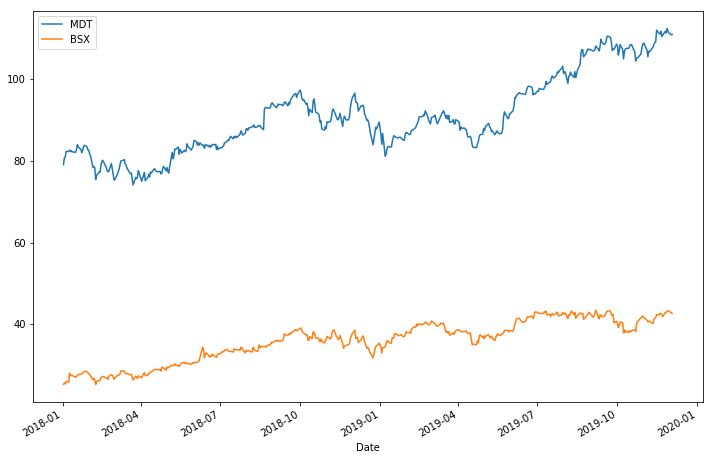

In [7]:
df_tickr1['Adj Close'].plot(label='{}'.format(ticker_1),figsize=(12,8))
df_tickr2['Adj Close'].plot(label='{}'.format(ticker_2))
plt.legend();

In [8]:
spread_ratio = df_tickr1['Adj Close']/df_tickr2['Adj Close']

In [9]:
def zscore(stocks):
    return (stocks - stocks.mean()) / np.std(stocks)

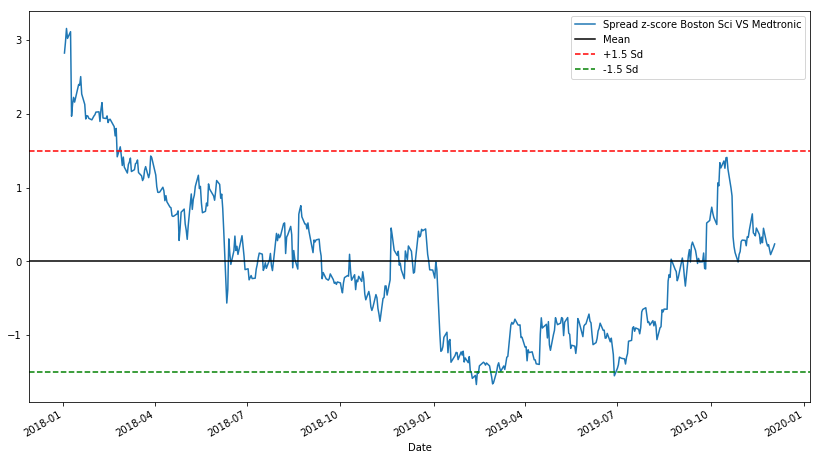

In [10]:
zscore(spread_ratio).plot(figsize=(14,8))
plt.axhline(zscore(spread_ratio).mean(), color='black')
plt.axhline(1.5, c='r', ls='--')
plt.axhline(-1.5, c='g', ls='--')
plt.legend(['Spread z-score Boston Sci VS Medtronic', 'Mean', '+1.5 Sd', '-1.5 Sd']);

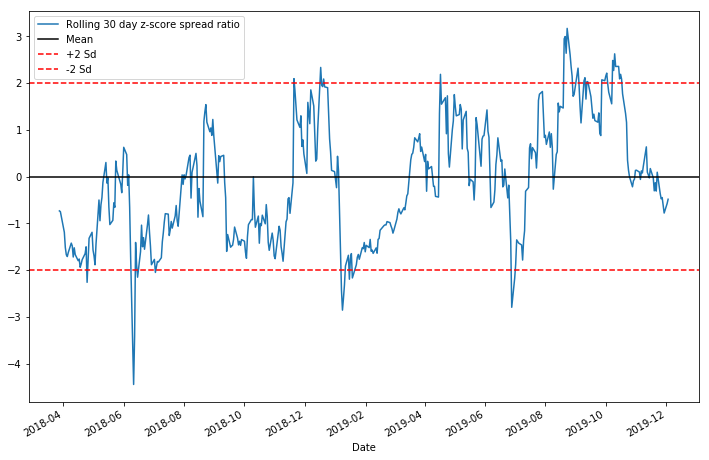

In [11]:
#1 day moving average of the price spread
spreadratio_mavg1 = spread_ratio.rolling(1).mean()

# 30 day moving average of the price spread
spreadratio_mavg30 = spread_ratio.rolling(60).mean()

# Take a rolling 30 day standard deviation
std_30ratio = spread_ratio.rolling(60).std()

# Compute the z score for each day
zscore_30_1_ratio = (spreadratio_mavg1 - spreadratio_mavg30)/std_30ratio



zscore_30_1_ratio.plot(figsize=(12,8),label='Rolling 30 day Z score for spread ratio')
plt.axhline(0, color='black')
plt.axhline(2.00, color='red', linestyle='--')
plt.axhline(-2.00, color='red',linestyle='--')
plt.legend(['Rolling 30 day z-score spread ratio', 'Mean', '+2 Sd', '-2 Sd']);

In [12]:
from statsmodels.tsa.stattools import coint

In [13]:
y0 = df_tickr1['Adj Close']
y1 = df_tickr2['Adj Close']

In [14]:
t_stat_summary = statsmodels.tsa.stattools.coint(y0, y1, trend='c', method='aeg', maxlag=None, autolag='aic', return_results=True) 

In [15]:
print('----------Co-Integration Test-------------------')
print('T-stat for the pair {} VS {}:'.format(ticker_1,ticker_2), t_stat_summary[0])
print('Alpha value for the T-stat:  {}'.format(t_stat_summary[1]))
print('--------------------------------------')
print('T-stat 99%:  {}'.format(t_stat_summary[2][0]))
print('T-stat 95%:  {}'.format(t_stat_summary[2][1]))
print('T-stat 90%:  {}'.format(t_stat_summary[2][2]))

----------Co-Integration Test-------------------
T-stat for the pair MDT VS BSX: -1.7461121733537683
Alpha value for the T-stat:  0.6555088577468715
--------------------------------------
T-stat 99%:  -3.9192584556494308
T-stat 95%:  -3.3488095575445045
T-stat 90%:  -3.0532426117390874


In [16]:
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('\n-----------Augmented Dickey-Fuller Test: ----------\n')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("\nstrong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary\n")
    else:
        print("\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary\n ")
    
    print("Dickey Fuller Confidence Intervals:  ", adfuller(spread_ratio)[4])

adf_check(spread_ratio)


-----------Augmented Dickey-Fuller Test: ----------

ADF Test Statistic : -3.1918561428636805
p-value : 0.020460943644585346
#Lags Used : 2
Number of Observations Used : 481

strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

Dickey Fuller Confidence Intervals:   {'1%': -3.4440184853599876, '5%': -2.867567599912013, '10%': -2.5699804779975883}


In [17]:
np.corrcoef(df_tickr1['Adj Close'],df_tickr2['Adj Close'])

array([[1.        , 0.85913237],
       [0.85913237, 1.        ]])

In [18]:
np.cov(df_tickr1['Adj Close'],df_tickr2['Adj Close'])

array([[93.21700317, 42.05118484],
       [42.05118484, 25.70047644]])

# Differencing method of spread; GARCH volatility method of spread and final use log returns minus average log returns of spread over GARCH - to be done next

In [19]:
zscore_30_1_ratio[-20:]

Date
2019-11-05   -0.059512
2019-11-06    0.122937
2019-11-07    0.079547
2019-11-08    0.229614
2019-11-11    0.637329
2019-11-12    0.096726
2019-11-13    0.039774
2019-11-14   -0.026559
2019-11-15    0.173453
2019-11-18   -0.025675
2019-11-19   -0.303892
2019-11-20   -0.129094
2019-11-21   -0.308906
2019-11-22    0.095165
2019-11-25   -0.361325
2019-11-26   -0.473224
2019-11-27   -0.447613
2019-11-29   -0.778474
2019-12-02   -0.575821
2019-12-03   -0.483392
Name: Adj Close, dtype: float64

In [20]:
spread_ratio[-10:]

Date
2019-11-19    2.605442
2019-11-20    2.623563
2019-11-21    2.608357
2019-11-22    2.648029
2019-11-25    2.608635
2019-11-26    2.599346
2019-11-27    2.602870
2019-11-29    2.575491
2019-12-02    2.596208
2019-12-03    2.604788
Name: Adj Close, dtype: float64

In [21]:
#differenced spread
t_series_lag_1 = spread_ratio.diff(1)

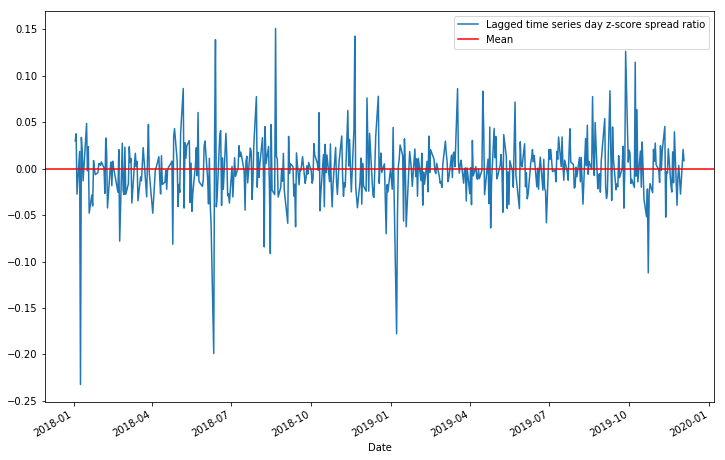

In [22]:
t_series_lag_1.plot(figsize=(12,8),label='Timeseries Lagged 1 day Z score')
plt.axhline(0, color='red')
#plt.axhline(2.0, color='red', linestyle='--')
#plt.axhline(3.0, color='red', linestyle='-')
#plt.axhline(-3.0, color='red', linestyle='-')
#plt.axhline(-2.0, color='red',linestyle='--')
plt.legend(['Lagged time series day z-score spread ratio', 'Mean', '2.0 Sd', '3.0 Sd']);

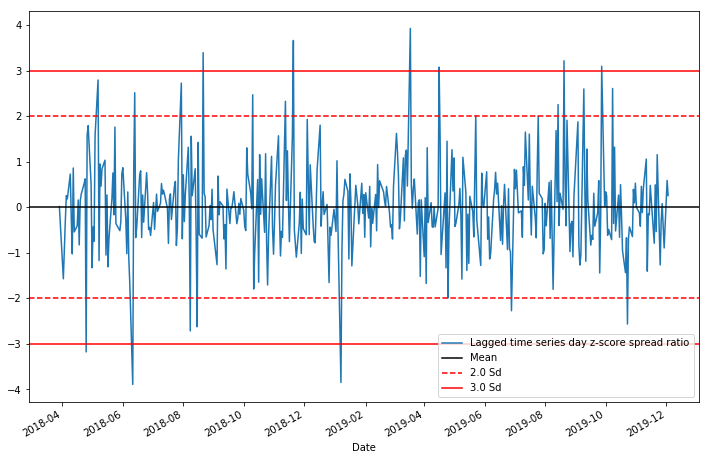

In [23]:
#1 day moving average of the price spread
spreadratio_t_series_lag_mavg_1 = t_series_lag_1.rolling(1).mean()

# Timeseries with one lag
spreadratio_t_series_lag_mavg_30 = t_series_lag_1.rolling(60).mean()

# Take a rolling 30 day standard deviation
std_dev_ratio = t_series_lag_1.rolling(30).std()

# Compute the z score for each day
zscore_t_series_lag = (spreadratio_t_series_lag_mavg_1 - spreadratio_t_series_lag_mavg_30)/std_dev_ratio



zscore_t_series_lag.plot(figsize=(12,8),label='Timeseries Lagged 1 day Z score for spread ratio')
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(3.0, color='red', linestyle='-')
plt.axhline(-3.0, color='red', linestyle='-')
plt.axhline(-2.0, color='red',linestyle='--')
plt.legend(['Lagged time series day z-score spread ratio', 'Mean', '2.0 Sd', '3.0 Sd']);

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
t_series_dropna = t_series_lag_1.dropna()

In [26]:
result = adfuller(t_series_dropna)
result

(-17.511112341959183,
 4.3344936532440085e-30,
 1,
 481,
 {'1%': -3.4440184853599876,
  '5%': -2.867567599912013,
  '10%': -2.5699804779975883},
 -1835.6232619469592)

In [27]:
# ADF check
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [28]:
adf_check(t_series_dropna)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -17.511112341959183
p-value : 4.3344936532440085e-30
#Lags Used : 1
Number of Observations Used : 481
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

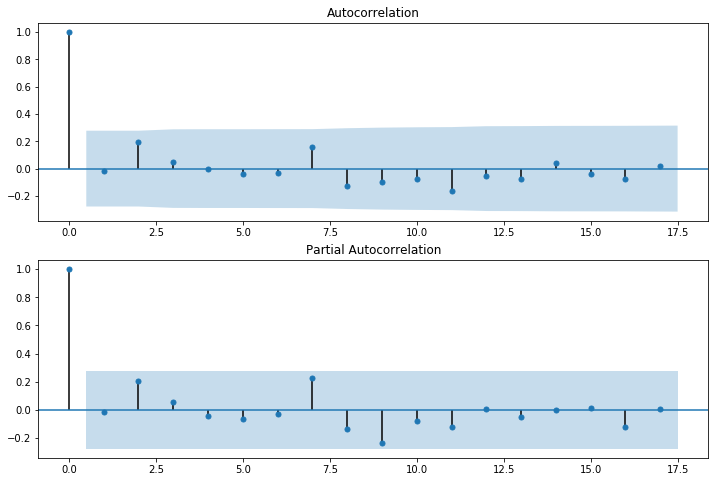

In [30]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(t_series_dropna.iloc[-50:],  ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(t_series_dropna.iloc[-50:], ax=ax2)

In [31]:
from statsmodels.tsa.arima_model import ARIMA

In [32]:
model = statsmodels.tsa.arima_model.ARIMA(t_series_dropna, order=(1,1,1))
results = model.fit()
print(results.summary())

C:\Users\samar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\samar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  482
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 931.557
Method:                       css-mle   S.D. of innovations              0.035
Date:                Wed, 04 Dec 2019   AIC                          -1855.114
Time:                        09:27:28   BIC                          -1838.402
Sample:                             1   HQIC                         -1848.546
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.603e-05   1.08e-05      1.479      0.140   -5.21e-06    3.73e-05
ar.L1.D.Adj Close    -0.0482      0.046     -1.058      0.291      -0.137       0.041
ma.L1.D.Adj Close    -1.

# Estimating GARCH

In [33]:
from arch import arch_model